In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
ma_list = [3,5,10,20,30]
stock_symbol = 'AAPL'

df = yf.Ticker(stock_symbol).history(period='max')
df = df.iloc[:,:-2]
df.reset_index(inplace=True)

# df['Premarket_Change'] = (df.Open - df.Close.shift(1))/df.Close.shift(1) <== With scaling (Percentage change)
df['Premarket_Change'] = df.Open - df.Close.shift(1)

# Get the shifted data
for day in [1,3,5,10]:
    for col in ['High','Low','Close','Volume']:
        df[f'{col}_Shift_{day}'] = df[col].shift(day)

# Get the Moving Average data
for col in ['Close','Volume']:
    for ma in ma_list:
        df[f'{col}_{ma}MA'] = df[col].rolling(ma).mean().shift(1)


df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(['Date','High','Low','Volume'], axis=1, inplace=True)
df['Return'] = (df.Close - df.Open)/df.Open
df = df[['Open'] + list(df.columns[2:]) + ['Close']] # Reordering the column

In [3]:
# Function that calculate the accuracy and profit made by the model
# MLmodel => the trained regression model
# test_set => the dataframe for test
# features => the list of features that used to train the MLmodel
def PnL(MLmodel, test_set, features, return_list=False):
    predict_y = MLmodel.predict(test_set[features])
    predict_return = (predict_y - test_set['Open'])/test_set['Open']
    actual_return = test_set['Return']

    test_call = np.array(actual_return > 0)
    predict_call = np.array(predict_return > 0)
    accuracy_rate = np.count_nonzero((test_call == predict_call) == True)/len(test_set)

    profit_list = [1]

    for i in range(len(test_set)):
        # Terminate the trade if the capital is not enough
        if profit_list[-1] <= 0:
            break
        
        if predict_return[i] > 0:
            profit_list.append(profit_list[-1] * (1 + actual_return[i]))
        else:
            profit_list.append(profit_list[-1])
    
    if return_list:
        return profit_list
    else:
        return profit_list[-1], accuracy_rate

In [4]:
%%time

train, test = df.iloc[:int(len(df)*0.8),:], df.iloc[int(len(df)*0.8):,:]
train.reset_index(drop = True, inplace=True)
test.reset_index(drop = True, inplace=True)

# Greedy algorithm
PnL_list = np.array([])
accuracy_list = []
selected_features = []
feature_list = list(df.columns[:-2])

for i in range(len(df.columns[:-2])):
    features_left = list(set(feature_list) - set(selected_features))
    PnL_sub_list = np.array([])
    accuracy_sub_list = []

    for f in features_left:
        feature_new = selected_features + [f]

        train_X, train_Y = train[feature_new], train['Close']
        model = LinearRegression()
        model.fit(train_X, train_Y)

        profit, accuracy = PnL(model, test, feature_new)
        PnL_sub_list = np.append(PnL_sub_list, profit)
        accuracy_sub_list.append(accuracy)

    selected_features += [features_left[PnL_sub_list.argmax()]]
    PnL_list = np.append(PnL_list, PnL_sub_list.max())
    accuracy_list.append(accuracy_sub_list[PnL_sub_list.argmax()])

best_features = selected_features[:PnL_list.argmax()+1]
print(f'The model preform better with features {best_features}')
print(f'Profit\t\t= {PnL_list.max()}')
print(f'Accuracy\t= {accuracy_list[PnL_list.argmax()]}')

The model preform better with features ['Low_Shift_3', 'Premarket_Change', 'Low_Shift_1', 'Low_Shift_5', 'High_Shift_3', 'Close_20MA', 'Close_Shift_5', 'Close_5MA', 'Volume_Shift_5', 'Volume_5MA', 'Volume_Shift_10']
Profit		= 5.443515109356987
Accuracy	= 0.5299472927647341
CPU times: user 32 s, sys: 31 s, total: 1min 2s
Wall time: 18.3 s


In [5]:
train_X, train_Y = train[best_features], train['Close']
model = LinearRegression()
model.fit(train_X, train_Y)

profit_list = PnL(model, test, best_features, return_list=True)

# Get the profit with buy-and-hold method
org_price = test['Open'][0]
hold_profit = []
for i in range(len(test)):
    hold_profit.append((test['Close'][i]-org_price)/org_price)

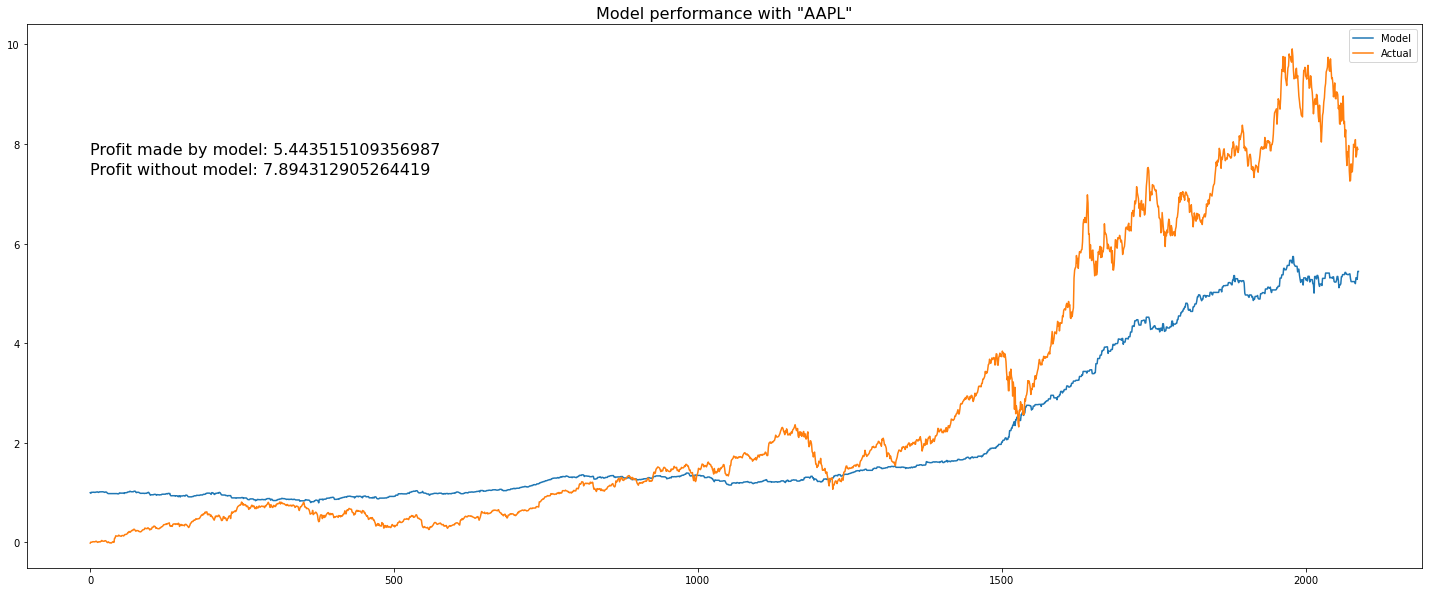

In [6]:
text_pos = max([round(hold_profit[-1]), round(profit_list[-1])])

fig = plt.figure(figsize=(25,10))
plt.plot(profit_list, label='Model')
plt.plot(hold_profit, label='Actual')
plt.text(0,text_pos-0.2, (f'Profit made by model: {profit_list[-1]}'), fontsize=16)
plt.text(0,text_pos-0.6, (f'Profit without model: {hold_profit[-1]}'), fontsize=16)
plt.title(f'Model performance with "{stock_symbol}"', fontsize=16)
plt.legend()
plt.show()